# Import the necessary libraries 

In [825]:
# imports necessary for preprocessing
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# NLP Imports
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
import re
# Code to download corpora
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Imports to create Neural Net and metrics associated
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import random
import tensorflow as tf

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Justi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Justi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load the data and check the basic information for this data set

In [826]:
# Load data in with read_csv
file_path = "../Data/Train_rev1.csv"
df = pd.read_csv(file_path)
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [827]:
# check the basic information of the data set, dtypes, null values, column names
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [828]:
# check the total null values  in each column since the above shows there are missing value
# based on this those 3 features should be dropped before removing the null values
df.isnull().sum()

Id                         0
Title                      1
FullDescription            0
LocationRaw                0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryRaw                  0
SalaryNormalized           0
SourceName                 1
dtype: int64

In [829]:
# Drop the columns that we won't need, Company, ContractType, ContractTime, SalaryRaw, LocationRaw, ID
new_df = df.drop(columns = ["Company", "ContractType", "ContractTime", "SalaryRaw", "LocationRaw", "Id", "SourceName"])
new_df.head()

,Title,FullDescription,LocationNormalized,Category,SalaryNormalized
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,Dorking,Engineering Jobs,25000
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,Glasgow,Engineering Jobs,30000
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,Hampshire,Engineering Jobs,30000
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,Surrey,Engineering Jobs,27500
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...",Surrey,Engineering Jobs,25000


In [830]:
# check datatypes again
new_df.dtypes

Title                 object
FullDescription       object
LocationNormalized    object
Category              object
SalaryNormalized       int64
dtype: object

In [831]:
# find how many null values are in the new_df
new_df.isnull().sum()

Title                 1
FullDescription       0
LocationNormalized    0
Category              0
SalaryNormalized      0
dtype: int64

In [832]:
# drop the null values of this dataframe
new_df.dropna(inplace = True)

In [833]:
# make sure the shape looks good, this will be helpful later on
new_df.shape

(244767, 5)

In [834]:
# slice the dataframe so there are less rows, the above indicates there are over 200k rows this will take a while for a ML model to run
sliced_df = new_df.loc[:5000, :]

### Import NLP libraires

* This will help me turn the job description into numerical data to run a ML model

In [835]:
# create a varialbe for wordnetlemmatizer
lemmatizer = WordNetLemmatizer()

### Create clean text function

* This function will be able to take the whole job description column and lemmatize and tokenize each word.
This will be helpful when I apply the count vectorizer

In [836]:
def clean_text(article):
    sw = set(stopwords.words('english'))
    sw_addons = {"k", "uk","also"} 
    # Substitute everything that is not a letter with an empty string
    regex = re.compile("[^a-zA-Z ]")
    # we sub in an extra character for anything that is not a character from the
    # above line of code
    re_clean = regex.sub('', article)
    # tokenize each word in the sentence
    words = word_tokenize(re_clean)
    # obtain the root word for each word 
    lem = [lemmatizer.lemmatize(word) for word in words]
    # obtain an output that is all lowercase and not in the stop words
    output = [word.lower() for word in lem if word.lower() not in sw.union(sw_addons)]
    output = ' '.join(output)
    return output

In [837]:
# test function on sliced df to make sure it is correct
clean_text(sliced_df["FullDescription"][0])

'engineering systems analyst dorking surrey salary client located dorking surrey looking engineering systems analyst client provides specialist software development keywords mathematical modelling risk analysis system modelling optimisation miser pioneeer engineering systems analyst dorking surrey salary'

In [838]:
# create new column that has the clean description of the job
sliced_df['CleanDescription'] = sliced_df['FullDescription'].apply(clean_text)
sliced_df.head()

C:\Users\Justi\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Title,FullDescription,LocationNormalized,Category,SalaryNormalized,CleanDescription
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,Dorking,Engineering Jobs,25000,engineering systems analyst dorking surrey sal...
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,Glasgow,Engineering Jobs,30000,stress engineer glasgow salary currently looki...
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,Hampshire,Engineering Jobs,30000,mathematical modeller simulation analyst opera...
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,Surrey,Engineering Jobs,27500,engineering systems analyst mathematical model...
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...",Surrey,Engineering Jobs,25000,pioneer miser engineering systems analyst dork...


* The countvectorizer will obtain how many times each word is used in all of the job descriptions. The min_df parameter when adjusted between 1-0 
will remove words that appear in less than 15% of the job descriptions in this case. 

In [839]:
# Calculating the COUNT for the working corpus.
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words="english", min_df=.15)
count_vectorizer = vectorizer.fit_transform(sliced_df["CleanDescription"])
words_df = pd.DataFrame(count_vectorizer.toarray(), columns=vectorizer.get_feature_names())
words_df.head()

,ability,able,agency,application,apply,area,available,based,benefit,business,...,support,team,time,today,training,vacancy,week,work,working,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,1,3,0,0,0,0,0,1,2,0
2,3,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,2,3,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [840]:
# since there are words that were missed with the stop words, I want to give each word an equal weight of one. I want to do this because
# I do not want the word "said" to out way the word "engineer" as an example
# Filter the dataframe so each word has a weight of 1 
filtered_df_2 = words_df.replace(list(range(1,100)),1)

In [841]:
filtered_df_2.head()

,ability,able,agency,application,apply,area,available,based,benefit,business,...,support,team,time,today,training,vacancy,week,work,working,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,1,1,0
2,1,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [842]:
# combine the two dataframes
combined_df = pd.concat([sliced_df, filtered_df_2], axis = 1)
combined_df.head()

,Title,FullDescription,LocationNormalized,Category,SalaryNormalized,CleanDescription,ability,able,agency,application,...,support,team,time,today,training,vacancy,week,work,working,year
0,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,Dorking,Engineering Jobs,25000.0,engineering systems analyst dorking surrey sal...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,Glasgow,Engineering Jobs,30000.0,stress engineer glasgow salary currently looki...,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,Hampshire,Engineering Jobs,30000.0,mathematical modeller simulation analyst opera...,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,Surrey,Engineering Jobs,27500.0,engineering systems analyst mathematical model...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...",Surrey,Engineering Jobs,25000.0,pioneer miser engineering systems analyst dork...,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [844]:
# drop the null values from the new dataframe
combined_df.dropna(inplace = True)

In [845]:
# drop the 2 description columns as we no longer need them
combined_df = combined_df.drop(columns = ["FullDescription", "CleanDescription", "Title", "LocationNormalized"])
combined_df.head()

,Category,SalaryNormalized,ability,able,agency,application,apply,area,available,based,...,support,team,time,today,training,vacancy,week,work,working,year
0,Engineering Jobs,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Engineering Jobs,30000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,Engineering Jobs,30000.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,Engineering Jobs,27500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Engineering Jobs,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [846]:
# use get dummies to turn the category columns into number columns
encoded_df = pd.get_dummies(combined_df)
encoded_df.head()

,SalaryNormalized,ability,able,agency,application,apply,area,available,based,benefit,...,Category_Other/General Jobs,"Category_PR, Advertising & Marketing Jobs",Category_Property Jobs,Category_Retail Jobs,Category_Sales Jobs,Category_Scientific & QA Jobs,Category_Social work Jobs,Category_Teaching Jobs,Category_Trade & Construction Jobs,Category_Travel Jobs
0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,30000.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,30000.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,27500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Prepare data for running a ML model

In [847]:
# split the dataset into X and y
X = encoded_df.drop(columns = ["SalaryNormalized"])
y = encoded_df["SalaryNormalized"].values.reshape(-1,1)

In [848]:
# look at the shape of each data set
X.shape

(4999, 126)

In [849]:
y.shape

(4999, 1)

In [850]:
# lets import train test split to split the data up
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   random_state=78)

In [851]:
# use MinMaxScaler to scale the date
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

In [853]:
# scale the training data
x_scaler.fit(X_train)
y_scaler.fit(y_train)
X_train_scaled = x_scaler.transform(X_train)
X_test_scaled = x_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled =y_scaler.transform(y_test)

In [856]:
# This will act as a random state variable....it might not be exact but it will be close to previous run
seed_value = 0
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [857]:
# first we need to define the number of hidden nodes and input features
# start with a shallow network and expand from there
# I am going to start with the number of columns as the input features
number_input_columns = X.shape[1]
number_hidden_nodes = (X.shape[1]*2)



# Create NN
neural_network = Sequential()

# create the input latter
neural_network.add(Dense(units = number_hidden_nodes, input_dim = number_input_columns, activation = "tanh", kernel_initializer='normal' ))
# create hidden layer
neural_network.add(Dense(units = number_hidden_nodes,  activation = "tanh", kernel_initializer='normal'))

# 2nd hidden layer
neural_network.add(Dense(units = number_hidden_nodes,  activation = "tanh", kernel_initializer='normal'))
# create output layer
neural_network.add(Dense(units = 1, activation = "linear", kernel_initializer='normal'))


In [858]:
# complie the NN and we can see how many total parameters along with how many parameters are in each layer
neural_network.compile(loss="mean_absolute_error", optimizer="adam", metrics=["mean_absolute_error"])
neural_network.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_287 (Dense)            (None, 252)               32004     
_________________________________________________________________
dense_288 (Dense)            (None, 252)               63756     
_________________________________________________________________
dense_289 (Dense)            (None, 252)               63756     
_________________________________________________________________
dense_290 (Dense)            (None, 1)                 253       
Total params: 159,769
Trainable params: 159,769
Non-trainable params: 0
_________________________________________________________________


In [859]:
# Fit the model to the training sets
nn_model = neural_network.fit(X_train_scaled, y_train_scaled,validation_split=0.2,epochs=20)

Epoch 1/20
94/94 [==============================] - 2s 18ms/step - loss: 0.1033 - mean_absolute_error: 0.1033 - val_loss: 0.0758 - val_mean_absolute_error: 0.0758
Epoch 2/20
94/94 [==============================] - 1s 15ms/step - loss: 0.0746 - mean_absolute_error: 0.0746 - val_loss: 0.0684 - val_mean_absolute_error: 0.0684
Epoch 3/20
94/94 [==============================] - 3s 30ms/step - loss: 0.0725 - mean_absolute_error: 0.0725 - val_loss: 0.0663 - val_mean_absolute_error: 0.0663
Epoch 4/20
94/94 [==============================] - 1s 14ms/step - loss: 0.0709 - mean_absolute_error: 0.0709 - val_loss: 0.0697 - val_mean_absolute_error: 0.0697
Epoch 5/20
94/94 [==============================] - 1s 13ms/step - loss: 0.0691 - mean_absolute_error: 0.0691 - val_loss: 0.0635 - val_mean_absolute_error: 0.0635
Epoch 6/20
94/94 [==============================] - 1s 13ms/step - loss: 0.0678 - mean_absolute_error: 0.0678 - val_loss: 0.0630 - val_mean_absolute_error: 0.0630
Epoch 7/20
94/94 [====

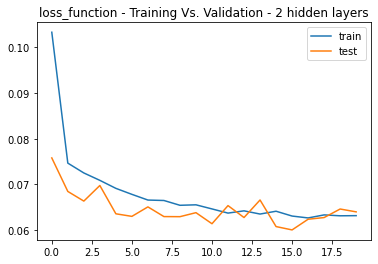

In [860]:
# Train vs test for shallow net
plt.plot(nn_model.history["loss"])
plt.plot(nn_model.history["val_loss"])
plt.title("loss_function - Training Vs. Validation - 2 hidden layers")
plt.legend(["train", "test"])
plt.show()
plt.close()

In [861]:
# evaluate the model
neural_network.evaluate(X_test_scaled, y_test_scaled)

40/40 [==============================] - 0s 5ms/step - loss: 0.0645 - mean_absolute_error: 0.0645


[0.06452938169240952, 0.06452938169240952]

In [862]:
# make predictions on X_test_scaled
predictions = neural_network.predict(X_test_scaled)

In [863]:
predicted_salaries = y_scaler.inverse_transform(predictions)
real_salaries = y_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

In [864]:
salaries = pd.DataFrame({
    "Real": real_salaries.ravel(),
    "Predicted": predicted_salaries.ravel()
}, index = df.index[-len(real_salaries): ]) 
salaries.head()

,Real,Predicted
243518,22000.0,27571.628906
243519,14880.0,23661.474609
243520,16320.0,16804.361328
243521,28800.0,29912.210938
243522,17280.0,24220.009766


In [865]:
# obtain the root mean square error, this will show how far off my predictions are
np.sqrt(mean_squared_error(real_salaries, predicted_salaries))

13372.340644713895